# Gradient Boosted Trees

In [9]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
import numpy

## Loading Data

As with all prior modeling, we drop `id` because it's just the identification number of each patient
We exclude `time_d` and `censor_d` because these seem unfair to include 
 in modeling since they contain information about time and censor
We chose not to include `txgrp` and `strat2` because they were derived 
(and thus highly correlated with) from other predictor variables. 

In [10]:
data = pd.read_csv("AIDSdata.csv")
data = data.drop(['id', 'time_d', 'censor_d', 'txgrp', 'strat2', 'time_d'], axis=1)

We next separate predictors and labels. Since XGBoost only allow one column for y, the censoring information is coded as negative values. 

In [11]:
# predictors
X = data[['tx', 'sex', 'raceth', 'ivdrug', 
          'hemophil', 'karnof', 'cd4', 'priorzdv', 'age']]

# labels
censorL = [c for c in data.censor]
timeL = [t for t in data.time]
time_censor = list(zip(censorL, timeL))
y = [x[1] if x[0] else -x[1] for x in time_censor]

We create a train and test split, then train the models. However, for a more ad-hoc approach, we train 80% of the data on a variety of values for `eta` (learning rate or shrinkage parameter), `max_depth` (maximum depth of each tree), `subsample` (fraction of observations to be random samples for each tree), and `lambda` (penalty parameter; the higher it is, the more regularization). From these trials, we chose the values which gave the highest Harrell C-statistic on the remaining held-out test set. The Harrell C-statistic measures how well we can order patients by their survival time, where 1 is a perfect ordering.

In [12]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [15]:
# just by messing 
params = {
    "eta": 0.002,
    "max_depth": 2,
    "objective": "survival:cox",
    "subsample": 0.5,
    "lambda": 1
    
}
model_train = xgboost.train(params, xgb_train, 10000, 
                            evals = [(xgb_test, "test")], verbose_eval=0)

In [16]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [17]:
# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8472803347280334

The highest C-statistic we have succeeded in obtaining is 0.847. Using these best parameter values, we train a model on the full dataset. This is the model we use from here on out. 

In [18]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 2, 
    "objective": "survival:cox",
    "subsample": 0.5,
    "lambda": 1
}
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_full, "test")], verbose_eval=0)

## Inference with SHAP values

To review the the more detailed explanation above, SHAP values are a way to perform inference on tree-based models. Their key advantage is that rather than simply giving an unsigned feature importance value, as was the case traditionally with tree-based models, SHAP values are signed. Thus, we can make inferences such as "higher values of x are associated with lower values of y."

### Feature Importance

In [19]:
shap_values = shap.TreeExplainer(model).shap_values(X)

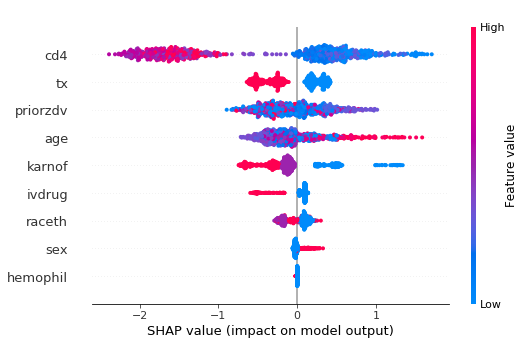

In [20]:
shap.summary_plot(shap_values, X)

In the above SHAP values plot, which replaces the familiar bar chart of feature importance for tree-based models, the predictors are listed from top to bottom in their order of importance in the model. Each dot represents one patient, and the colors represent the range of the effects of each feature within the dataset. These colors enable us to relate how changes in the values of each predictor are associated with the change in hazard. The SHAP values are plotted on the x-axis. Higher SHAP values represent higher risk of death or AIDS diagnosis associated with each explanatory variable.

We can observe that the primary risk factor for death or AIDS diagnosis is Baseline CD4 count (`cd4`) as it is the first predictor listed in the SHAP values plot. The lower the CD4 (bluer dots), the higher the risk of dying or being diagnosed with AIDS. 

The next most important risk factor is the IDV treatment, `tx`. Patients who did recieve the IDV treatment (red) have a lower risk of being diagnosed with AIDS or dying as compared to those who did not recieve the IDV treatment. 

Another interesting important risk factor is `age`. Although among younger to middle-aged people the risk of death or diagnosis is around the same, older patients are definitely more likely to die or be diagnosed with age.

A final informative risk factor is Karnofsky Performance Scale (`karnof`). As expected, the higher the Karnofsky score of a patient, the lower their risk of death or diagnosis. 

### Interactions

We first calculate all SHAP interaction values which may be interpreted as the difference between SHAP values for feature i when feature j is present and the SHAP values for feature i when feature j is absent. Note that SHAP interaction values are commutative because we take the sum of the interaction effects to get the total interaction effect (interaction of i and j written $\iota_{i,j}$ is the same as the interaction of j and i written $\iota_{j,i}$ and the total interaction effect is $\iota_{i,j} + \iota_{j,i}$). The main effect is then defined as the difference between the SHAP values and the SHAP interaction values for a given feature.

In [21]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)

We produce SHAP interaction values which separate the impact of two predictors into main effects and interaction effects. Doing this, we reveal an interesting interaction effect with age and sex. 

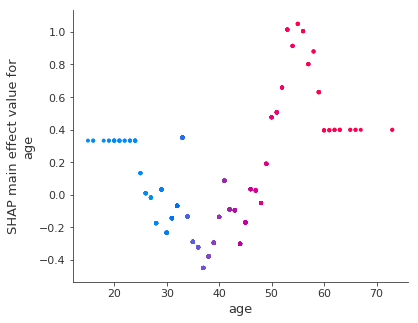

In [22]:
shap.dependence_plot(
    ("age", "age"),
    shap_interaction_values, X,
    display_features=X
)

In the plot above, we examine the main effect of age on risk of death or diagnosis. Each dot is a single individual. On the x-axis age is plotted and on the y-axis, the SHAP main effect value for age displayed. Higher SHAP values represent higher risk of death or AIDS diagnosis associated with the the interaction effect of age and sex. In general, older people are at greater risk of death or diagnosis (as alluded to in the preceeding feature importance).

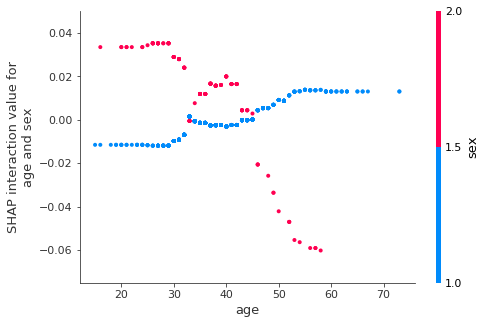

In [23]:
shap.dependence_plot(
    ("age", "sex"),
    shap_interaction_values, X,
    display_features=X
)

However, looking at the interaction effect of age and sex, we notice an interesting result. In the above plot, each dot is a single individual. On the x-axis, their age is plotted and on the y-axis, the SHAP interaction value for age and sex is displayed. Higher SHAP values represent higher risk of death or AIDS diagnosis associated with the the interaction effect of age and sex. Coloring each dot by age reveals that females are at greater risk of death or diagnosis at younger ages than males, but at older ages, males are more at risk. 

We also wanted to investigate why, although months of prior ZDV ues (`priorzdv`) is supposedly the third-most important feature in the XGBoost model, the feauture importance plot (very first plot) appears to show no real association between `priorzdv` and risk (low values of `priorzdv`, shown in blue, are sometimes associated with higher risk and sometimes associated with lower risk!). By looking at the main effect for `priorzdv` below, we observe this phenomenon again.

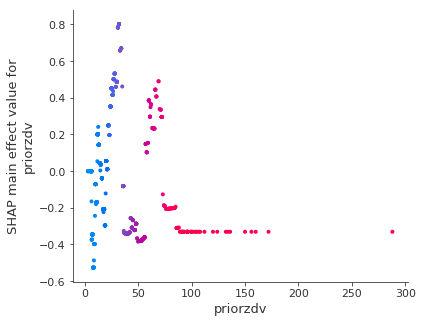

In [24]:
shap.dependence_plot(
    ("priorzdv", "priorzdv"),
    shap_interaction_values, X,
    display_features=X
)

From the above plot, we observe that sometimes low values of `priorzdv` are associated with low SHAP values (lower risk of AIDS diagnosis or death) while for other individuals, low values of `priorzdv` are associated with high SHAP values (high risk of AIDS diagnosis or death). 

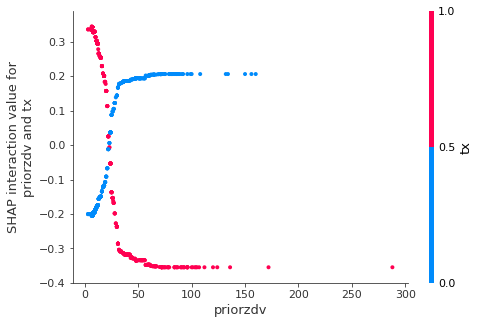

In [25]:
shap.dependence_plot(
    ("priorzdv", "tx"),
    shap_interaction_values, X,
    display_features=X
)

However, when observing the interaction effects of number of months of prior ZDV (`priorzdv`) and whether each patient got an IDV treatment (`tx`), we see a clear difference between the treatment groups. For patients who received the IDV treament, more months of prior ZDV use is associated with lower risk of diagnosis or death. However, for patients who did not receive the IDV treatment, more months of prior ZDV use is associated with higher risk of diagnosis or death.

# Discussion and Concluding Remarks
Overall, our model points to IDV treatment, Karnofsky score, and cd4 levels as important predictors for predicting time to death (or diagnosis). As seen in figure 10, an increase in cd4 is associated with a statistically significant decrease in the log hazard ratio, which is sensible since cd4 cell count is a well-regarded indicator for the presence of HIV -- the lower the cd4 count, the higher the activity of the HIV virus killing off these cells. Furthermore, when the Karnofsky score goes from 70 to 90, we observe a signficant three-fold increase in hazard. This result may even serve to help validate the Karnofsky performance metric intrinsically. In addition, Figure 5, our model fit, and Figures 10 both show that there is a significant difference between the control and treatment groups regarding survival, with the treatment group having a higher survival. The XGBoost analysis reinforces the importance of cd4 count, treatment, and Karnofsky score as predictors while also revealing an interesting interaction between prior ZDV use and treatment. 

Thus, given that this was an experimental study, we conclude that the treatment containing IDV significantly increases survival after adjusting for cd4 levels and Karnofsky score. We are willing to generalize this claim to patients who have no more than 200 CD4 cells/cubic millimeters, at least 3 months of prior ZDV therapy, and who reside in the United States since those were the inclusion criteria for this study. 

# References
1. https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf
2. https://xgboost.readthedocs.io/en/latest/tutorials/model.html
3. https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html
4. https://statisticalhorizons.com/multicollinearity (Great article on multicollinearity)
5. Harrell, F. (2015) Regression Modeling Strategies. (great textbook on all things survival analysis)
6. https://www.datacamp.com/community/tutorials/bootstrap-r (Overview of bootstrapping)
7. https://stats.stackexchange.com/questions/22017/sample-size-and-cross-validation-methods-for-cox-regression-predictive-models
8. https://stats.stackexchange.com/questions/18084/collinearity-between-categorical-variables (Explanation of VIF for Categorical Variables)
9. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
10. https://stackoverflow.com/questions/53562813/xgboost-cox-survival-time-entry
11. https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
12. https://arxiv.org/pdf/1802.03888.pdf
13. http://www.saedsayad.com/docs/gbm2.pdf
14. https://arxiv.org/pdf/1701.07926.pdf
15. https://www.hindawi.com/journals/cmmm/2013/873595/
16. https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83
17. http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf